In [282]:
import contextlib, datetime, glob, io, json, math, pandas, objectdetectiontools, os, PIL, random, copy, numpy, seaborn, shutil, statistics, torch
import matplotlib.pyplot as plt
import torchvision.models.detection as models
import torchvision.transforms as transforms
from torchvision.datasets import VisionDataset
from torchvision.transforms.functional import to_tensor

print("Is CUDA available?", torch.cuda.is_available())

Is CUDA available? False


# Ensure REPRODUCIBILITY

In [283]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
numpy.random.seed(42)

# 🏗️ Set up
Torchvision offers object detection reference scipts that can be used to get started quickly. This notebook uses those scripts and downloads them if they are not present yet. Also, a working folder named `output` is created, and a plotting function is defined.

In [284]:
random_state = 42
data_path = "data"
output_path = "output"


files = ["coco_eval.py", "coco_utils_meta.py", "engine_meta.py", "transforms.py", "utils.py"]
for f in files:
    if not os.path.exists(f):
        wget.download("https://raw.githubusercontent.com/pytorch/vision/main/references/detection/" + f, f)
from engine_meta import train_one_epoch, evaluate

if not os.path.exists(output_path):
    os.mkdir(output_path)

def barplot(df, y, x, title, palette=seaborn.color_palette("deep"), orient="h"):
    plt.figure(figsize=(len(plot_data)/6,len(plot_data)/4))
    ax = seaborn.barplot(data=plot_data, y=y, x=x, orient=orient, palette=palette, dodge=False)
    ax.set_title(label=title, loc="left")
    ax.set_xlim(0, 1 + int(plot_data[x].max()) * 1.2)
    ax.set_xlabel(str(int(plot_data[x].sum())) + " " + ax.get_xlabel())
    for i in ax.containers:
        ax.bar_label(i,)

# ⚛️ Select a pretrained model

Here the F-RCCN model that was pretrained with the [resnet50 feature pyramid network v2](https://arxiv.org/pdf/2111.11429.pdf) backbone is selected as the base model. The ideal image size (`target_size`) can be specified for testing purposes, or is inferred from the model's transform **maximum** input size. The reason for selecting the maximum rather than the mean of the maximum and the minimum is that the minor quality loss as a result of downscaling input images is considered less than the quality loss as a result of cutting through bounding boxes when making tiles in the preprocessing step. So making the least number of tiles is preferred. Given the input image size of 6720 x 4480, using the maximum, and therefore accepting a small loss in resolution results in 15 tiles per input images, whereas using the mean of minimum and maximum (~1024) results in 24 tiles, greatly increasing the number of potentially sliced bounding boxes.

- `target_size` Ideal size for the input images, if 0 then it will be inferred from the selected model.

In [285]:
target_size = 0

model_name ='resnet50'# ['mobilenet','resnet50'] #<resnet better
if model_name  =='mobilenet':
    model = models.fasterrcnn_mobilenet_v3_large_320_fpn(weights="DEFAULT")
else:
    model = models.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

target_size = model.transform.max_size if target_size == 0 else target_size
print("The target_size for input images is", target_size)

The target_size for input images is 1333


# Adjust Faster R-CNN classifier

In [286]:
from torch.jit.annotations import List, Dict
from torchvision.models.detection import roi_heads

def new_roi_forward(self, features, proposals, image_shapes, targets=None, meta_data=None):
    # type: (Dict[str, Tensor], List[Tensor], List[Tuple[int, int]], Optional[List[Dict[str, Tensor]]])
    """
    Arguments:
        features (List[Tensor])
        proposals (List[Tensor[N, 4]])
        image_shapes (List[Tuple[H, W]])
        targets (List[Dict])
    """
    if targets is not None:
        for t in targets:
            # TODO: https://github.com/pytorch/pytorch/issues/26731
            floating_point_types = (torch.float, torch.double, torch.half)
            assert t["boxes"].dtype in floating_point_types, 'target boxes must of float type'
            assert t["labels"].dtype == torch.int64, 'target labels must of int64 type'
            if self.has_keypoint():
                assert t["keypoints"].dtype == torch.float32, 'target keypoints must of float type'

    if self.training:
        proposals, matched_idxs, labels, regression_targets = self.select_training_samples(proposals, targets)
    else:
        labels = None
        regression_targets = None
        matched_idxs = None

    box_features = self.box_roi_pool(features, proposals, image_shapes)
    box_features = self.box_head(box_features)
    class_logits, box_regression = self.box_predictor(box_features, meta_data)

    result = torch.jit.annotate(List[Dict[str, torch.Tensor]], [])
    losses = {}
    if self.training:
        assert labels is not None and regression_targets is not None
        loss_classifier, loss_box_reg = roi_heads.fastrcnn_loss(
            class_logits, box_regression, labels, regression_targets)
        losses = {
            "loss_classifier": loss_classifier,
            "loss_box_reg": loss_box_reg
        }
    else:
        boxes, scores, labels = self.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
        num_images = len(boxes)
        for i in range(num_images):
            result.append(
                {
                    "boxes": boxes[i],
                    "labels": labels[i],
                    "scores": scores[i],
                }
            )

    if self.has_mask():
        mask_proposals = [p["boxes"] for p in result]
        if self.training:
            assert matched_idxs is not None
            # during training, only focus on positive boxes
            num_images = len(proposals)
            mask_proposals = []
            pos_matched_idxs = []
            for img_id in range(num_images):
                pos = torch.nonzero(labels[img_id] > 0).squeeze(1)
                mask_proposals.append(proposals[img_id][pos])
                pos_matched_idxs.append(matched_idxs[img_id][pos])
        else:
            pos_matched_idxs = None

        if self.mask_roi_pool is not None:
            mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
            mask_features = self.mask_head(mask_features)
            mask_logits = self.mask_predictor(mask_features)
        else:
            mask_logits = torch.tensor(0)
            raise Exception("Expected mask_roi_pool to be not None")

        loss_mask = {}
        if self.training:
            assert targets is not None
            assert pos_matched_idxs is not None
            assert mask_logits is not None

            gt_masks = [t["masks"] for t in targets]
            gt_labels = [t["labels"] for t in targets]
            rcnn_loss_mask = maskrcnn_loss(
                mask_logits, mask_proposals,
                gt_masks, gt_labels, pos_matched_idxs)
            loss_mask = {
                "loss_mask": rcnn_loss_mask
            }
        else:
            labels = [r["labels"] for r in result]
            masks_probs = maskrcnn_inference(mask_logits, labels)
            for mask_prob, r in zip(masks_probs, result):
                r["masks"] = mask_prob

        losses.update(loss_mask)

    # keep none checks in if conditional so torchscript will conditionally
    # compile each branch
    if self.keypoint_roi_pool is not None and self.keypoint_head is not None \
            and self.keypoint_predictor is not None:
        keypoint_proposals = [p["boxes"] for p in result]
        if self.training:
            # during training, only focus on positive boxes
            num_images = len(proposals)
            keypoint_proposals = []
            pos_matched_idxs = []
            assert matched_idxs is not None
            for img_id in range(num_images):
                pos = torch.nonzero(labels[img_id] > 0).squeeze(1)
                keypoint_proposals.append(proposals[img_id][pos])
                pos_matched_idxs.append(matched_idxs[img_id][pos])
        else:
            pos_matched_idxs = None

        keypoint_features = self.keypoint_roi_pool(features, keypoint_proposals, image_shapes)
        keypoint_features = self.keypoint_head(keypoint_features)
        keypoint_logits = self.keypoint_predictor(keypoint_features)

        loss_keypoint = {}
        if self.training:
            assert targets is not None
            assert pos_matched_idxs is not None

            gt_keypoints = [t["keypoints"] for t in targets]
            rcnn_loss_keypoint = keypointrcnn_loss(
                keypoint_logits, keypoint_proposals,
                gt_keypoints, pos_matched_idxs)
            loss_keypoint = {
                "loss_keypoint": rcnn_loss_keypoint
            }
        else:
            assert keypoint_logits is not None
            assert keypoint_proposals is not None

            keypoints_probs, kp_scores = keypointrcnn_inference(keypoint_logits, keypoint_proposals)
            for keypoint_prob, kps, r in zip(keypoints_probs, kp_scores, result):
                r["keypoints"] = keypoint_prob
                r["keypoints_scores"] = kps

        losses.update(loss_keypoint)

    return result, losses

# add new_forward function in RoiHeads of the FastRCNN model instance as a class method
bound_method = new_roi_forward.__get__(model.roi_heads, model.roi_heads.forward)
setattr(model.roi_heads, 'forward', bound_method)

In [287]:
import warnings
from collections import OrderedDict
from typing import List, Tuple

def new_forward(self, images, targets=None, meta_data=None):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]])
    """
    Arguments:
        images (list[Tensor]): images to be processed
        targets (list[Dict[Tensor]]): ground-truth boxes present in the image (optional)

    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            During training, it returns a dict[Tensor] which contains the losses.
            During testing, it returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).

    """
    if self.training and targets is None:
        raise ValueError("In training mode, targets should be passed")
    original_image_sizes = torch.jit.annotate(List[Tuple[int, int]], [])
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = self.transform(images, targets)
    
    features = self.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([('0', features)])
    proposals, proposal_losses = self.rpn(images, features, targets)
    detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets, meta_data)
    detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)

    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)

    if torch.jit.is_scripting():
        if not self._has_warned:
            warnings.warn("RCNN always returns a (Losses, Detections) tuple in scripting")
            self._has_warned = True
        return (losses, detections)
    else:
        return self.eager_outputs(losses, detections)

# add new_forward function to the FastRCNN model instance as a class method
bound_method = new_forward.__get__(model, model.__class__)
setattr(model, 'forward', bound_method)

In [288]:
from torch import tensor, cat
import torch.nn.functional as F

class FeatureFusionFastRCNNPredictor(torch.nn.Module):
    
    def __init__(self, in_channels, num_classes, mode="concat", learned_feature=False):
        super(FeatureFusionFastRCNNPredictor, self).__init__()

        self.mode = mode
        self.learned_feature=learned_feature
        self.num_classes=num_classes
    
        self.meta_learner = torch.nn.Sequential(
                torch.nn.Linear(num_classes-1, 1024),
                torch.nn.Sigmoid()
                )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(num_classes*2, 1024),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(512, num_classes)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(7, 4)
        )

        if mode=="simple":
            self.cls_score = torch.nn.Linear(in_channels, num_classes)
        elif self.mode == "concat" and self.learned_feature is False:
            self.cls_score = torch.nn.Linear(in_channels + num_classes - 1, num_classes)
        elif self.mode == "concat" and self.learned_feature is True:
            #self.cls_score = torch.nn.Linear(in_channels + num_classes, num_classes)
            self.cls_score = torch.nn.Linear(in_channels*2, num_classes)
        elif self.mode == "late":
           
            self.cls_score = torch.nn.Linear(in_channels, num_classes)

            self.meta_learner = torch.nn.Sequential(
                torch.nn.Linear(num_classes-1, num_classes),
                torch.nn.ReLU(inplace=True)
                )
        else:
            self.cls_score = torch.nn.Linear(in_channels, num_classes)

            self.meta_learner = torch.nn.Sequential(
                torch.nn.Linear(num_classes-1, 1024),
                torch.nn.Sigmoid()
            )
       
        self.bbox_pred = torch.nn.Linear(in_channels, num_classes * 4)

    def forward(self, x, meta_data):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)

        #arrange meta data into 1D tensor; for a batch_size > 1 the tensor will be batch_size * n_meta_features else n_meta_features
        meta_data = torch.stack(meta_data)

        metadata = torch.tensor([]).to("cuda")

        batch_size = 1 
        
        if self.learned_feature is True or self.mode=='late':

            metadata=torch.tensor([]).to("cuda")

            if self.mode != "late":
                meta_data = self.meta_learner.forward(meta_data)

            for i in range(0, batch_size):

                    meta = (torch.tensor(meta_data[i])).repeat((int)(x.size(dim=0)/batch_size), 1).to("cuda")

                    metadata = cat([metadata, meta], 0)

            metadata.to("cuda")

            # for concatenation
            if self.mode == "concat":

                x_new = torch.cat((x, metadata), dim=1)

                scores = self.cls_score(x_new)
              
                bbox_deltas = self.bbox_pred(x)

                return scores, bbox_deltas
                
            # for element-wise addition
            if self.mode == "add":

                x_new = torch.add(x, meta)
               
            # for element-wise multiplication
            if self.mode == "multiply":

                x_new = torch.mul(x, meta)

        else:
            
            metadata = (torch.tensor(meta_data)).repeat((int)(x.size(dim=0)), 1).to("cuda")
            
            x_new = torch.cat((x, metadata), dim=1)
       
        if self.mode == "simple":
            scores = self.cls_score(x)
        else:
            scores = self.cls_score(x_new)
        
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

Select type of fusion; simple is wihtout any fusion.

In [289]:
mode = "simple"# ["concat", "multiply", "add", "simple", "late"]
learned_feature = False 

model.roi_heads.box_predictor = FeatureFusionFastRCNNPredictor(model.roi_heads.box_predictor.cls_score.in_features, 4, mode=mode, learned_feature=learned_feature)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# 🎴 Preprocessing input images
In case the input images are significantly larger than the input size for the model to train, and the bounding boxes for the objects are relatively small, the problem could arise that when the large input image is automatically resized, the objects inside the bounding boxes degrade greatly in resolution. Therefore, it is better to have input images that are closer to the correct input size for the model (target_size), and having bounding boxes that are relatively large in respect to the input images. A helper function is used to slice the input images into slices that are close to the target size.

  - `wubble_margin` The number of pixels as a fraction of the slice width/height that a slicing line may move to become less destructive. *Coined by Gerard Schouten after been explained about the behaviour of how the line moves to the least destructive position "Oh, so it wubbles?", as in 'clumsily move from one side to the other'*.
  - `input_path` The path that the preprocessed images should be saved to.
  - `data_file` The file containing all annotations after preprocessing.
  - `force_preprocessing` If the file at `data_file` already exists, preprocessing will be skipped. Set this to True, to preprocess regardless.

In [290]:
wubble_margin = .2
input_path = "input"
data_file = "data.csv"
force_preprocessing = False
_tiletag = "___tile-"

def partition(annotations: list, size: int, margin: float, input_path: str, output_path: str) -> list:
    result = []
    line_margin = int(size * margin)
    filenames = []
    for obj in annotations:
        filename = obj["filename"]
        if not filename in filenames:
            filenames.append(filename)
    for filename in filenames:
        objects = [x for x in annotations if x["filename"] == filename]
        width, height = objects[0]["width"], objects[0]["height"]
        image = PIL.Image.open(os.path.join(input_path, filename))
        filename, fileext = os.path.splitext(filename)
        vertical_num = int(width / size)
        vertical_size = int(width / vertical_num)
        num_vertical_lines = vertical_num -1
        vertical_lines = []
        for i in range(1, num_vertical_lines +1):
            line = i * vertical_size
            line = _get_slice_line(line, line_margin, objects, "xmin", "xmax")
            vertical_lines.append(line)
        vertical_lines.append(width)
        horizontal_num = int(height / size)
        horizontal_size = int(height / horizontal_num)
        num_horizontal_lines = horizontal_num -1
        horizontal_lines = []
        for i in range(1, num_horizontal_lines +1):
            line = i * horizontal_size
            line = _get_slice_line(line, line_margin, objects, "ymin", "ymax")
            horizontal_lines.append(line)
        horizontal_lines.append(height)  
        prev_v = 0
        prev_h = 0
        row = 0
        for h in horizontal_lines:
            number = 0
            row = row + 1
            for v in vertical_lines:
                number = number +1
                new_filename = filename + _tiletag + _get_row_letter(row) + str(number) + fileext
                for obj in [x for x in objects if (x["xmin"] < v and x["xmin"] > prev_v and x["ymin"] < h and x["ymin"] > prev_h) or (x["xmax"] < v and x["xmax"] > prev_v and x["ymax"] < h and x["ymax"] > prev_h)]:
                    # Fixing sliced bounding boxes.
                    if obj["xmin"] < prev_v and obj["xmax"] > prev_v:
                        if obj["xmax"] - prev_v > int((obj["xmax"] - obj["xmin"])/2):
                            obj["xmin"] = prev_v
                        else:
                            continue
                    if obj["xmin"] < v and obj["xmax"] > v:
                        if v - obj["xmin"] > int((obj["xmax"] - obj["xmin"])/2):
                            obj["xmax"] = v
                        else:
                            continue
                    if obj["ymin"] < prev_h and obj["ymax"] > prev_h:
                        if obj["ymax"] - prev_h > int((obj["ymax"] - obj["ymin"])/2):
                            obj["ymin"] = prev_h
                        else:
                            continue
                    if obj["ymin"] < h and obj["ymax"] > h:
                        if h - obj["ymin"] > int((obj["ymax"] - obj["ymin"])/2):
                            obj["ymax"] = h
                        else:
                            continue
                    # Adjust bounding boxes.
                    obj["filename"] = new_filename
                    obj["width"] = v - prev_v
                    obj["height"] = h - prev_h
                    obj_w = obj["xmax"] - obj["xmin"]
                    obj_h = obj["ymax"] - obj["ymin"]
                    obj["xmin"] = obj["xmin"] - prev_v
                    obj["ymin"] = obj["ymin"] - prev_h
                    obj["xmax"] = obj["xmin"] + obj_w
                    obj["ymax"] = obj["ymin"] + obj_h
                    date = ''.join(filter(str.isdigit, filename))
                    from datetime import datetime
                    obj["date"] = datetime.strptime(date, '%Y%m%d%H%M%S')
                    obj["day"] = datetime.strptime(date, '%Y%m%d%H%M%S').timetuple().tm_yday
                    result.append(obj)
                tile = image.crop((prev_v, prev_h, v, h))
                tile.save(os.path.join(output_path, new_filename))
                prev_v = v
            prev_h = h
            prev_v = 0
    return result

def _get_slice_line(mid, margin, objects, min_index, max_index):
    if margin == 0:
        return mid
    results = dict()
    for d in range(margin):
        for delta in {d, d*-1}:
            line = mid + delta
            count = sum([1 for obj in objects if (obj[min_index] < line and obj[max_index] >= line)])
            if count == 0: # Return if a 'perfect' line is found.
                return line
            results[line] = count
    return min(zip(results.values(), results.keys()))[1] # Return the line with the least sliced objects.

def _get_row_letter(row): 
    return str(chr(ord('`')+row))

if force_preprocessing or not os.path.exists(input_path) or not os.path.exists(os.path.join(input_path, data_file)):
    annotations = objectdetectiontools.reader.load_pvoc_annotations(data_path) 
    if os.path.exists(input_path):
        shutil.rmtree(input_path)
    os.mkdir(input_path)
    data = partition(annotations, target_size, wubble_margin, data_path, input_path)
    pandas.DataFrame(data).to_csv(os.path.join(input_path, "data.csv"), index=False)
df = pandas.read_csv(os.path.join(input_path, data_file))

# 🎆 Demonstrating a preprocessing result
The following code demonstrates the result of the preprocessing step, given the filename of an original image. If no filename is given, it takes a random original image. This cell can be re-run to get a another random image.

  - `demo_image` The filename of the original image for which the preprocessing result should be demonstrated. Can be left empty to take a random original image.

Image: data/20220606184647-Marsh.jpg


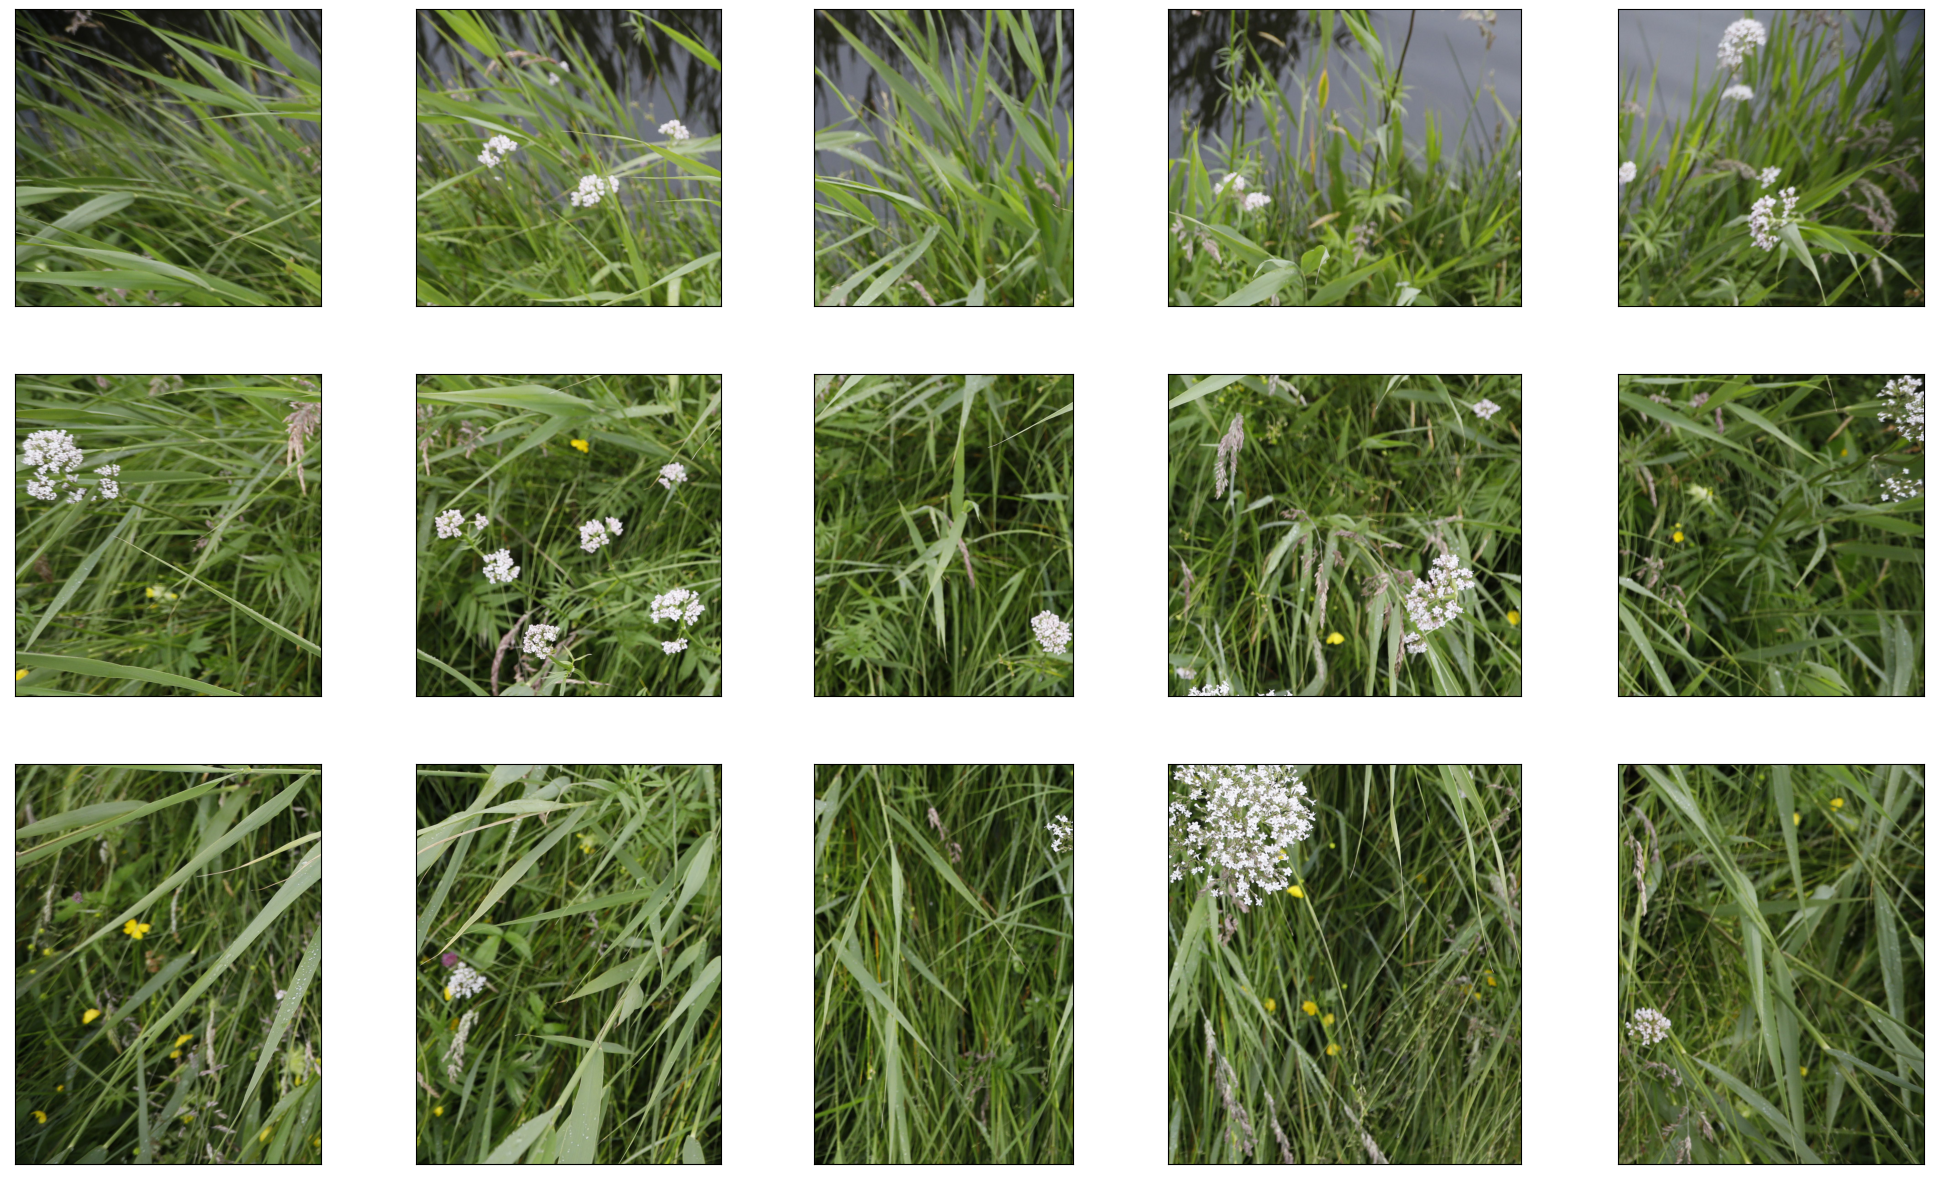

In [291]:
demo_image = ""

if demo_image == "":
    filenames = list(set(x["filename"] for x in df.to_dict("records")))
    demo_image = random.sample(filenames, k=1)[0]
    _, ext = os.path.splitext(demo_image)
    demo_image = os.path.join(data_path, demo_image[:demo_image.index(objectdetectiontools.images._tiletag)]+ext)

print("Image:", demo_image)
images, rows, columns, ratios_w, ratios_h = objectdetectiontools.images.collect(input_path, demo_image)
fig, subplots = plt.subplots(nrows=rows, ncols=columns, figsize=(25,15), gridspec_kw={"width_ratios":ratios_w, "height_ratios":ratios_h})
subplots = subplots.flatten()
for i in range(len(images)):
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])
    subplots[i].imshow(images[i])

# 🔭 Observations overview
An overview of the number of observations per label is presented below.

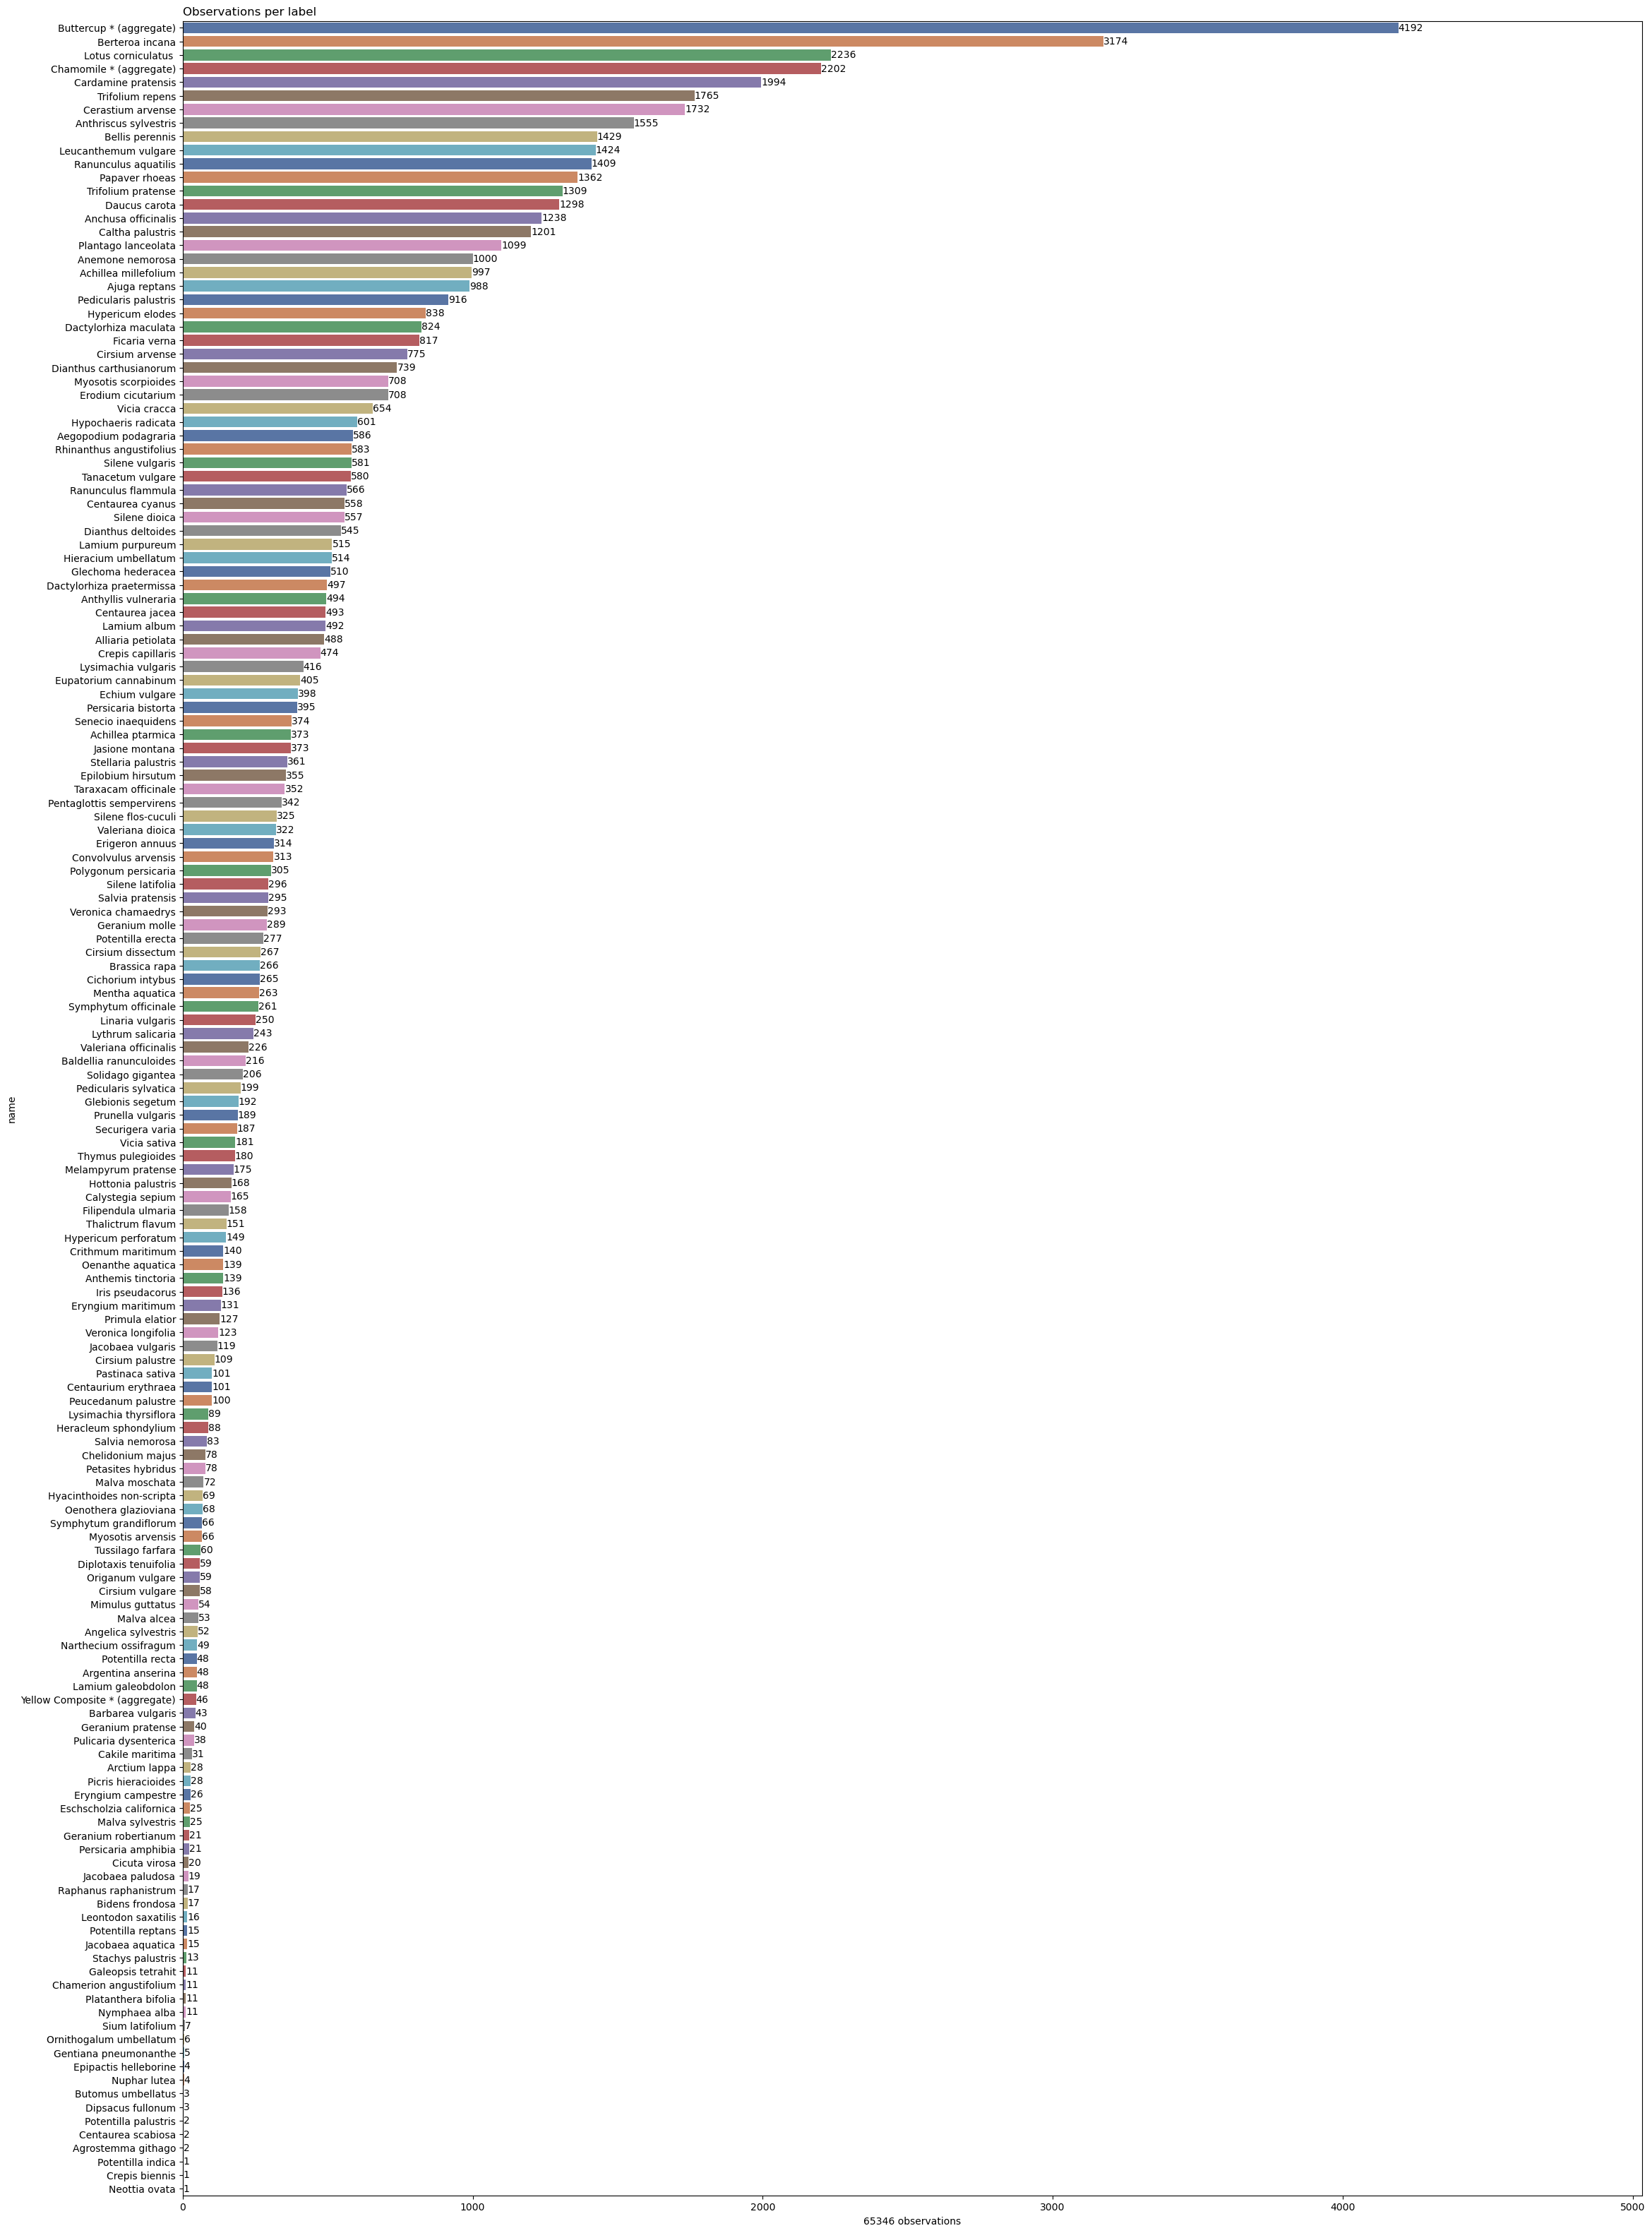

In [292]:
plot_data = df.groupby(by=["name"])["width"].count().rename("observations").reset_index().sort_values(by="observations", ascending=False)
barplot(plot_data, "name", "observations", "Observations per label")

# Meta-data

Species:

160


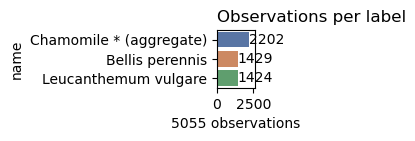

In [293]:
group1 = ['Buttercup * (aggregate)', 'Caltha palustris','Ficaria verna']#, 'Ranunculus flammula']
group2 = ['Bellis perennis', 'Chamomile * (aggregate)', 'Leucanthemum vulgare']
group4 = ['Centaurea jacea', 'Jasione montana', 'Cirsium arvense']#, 'Cirsium dissectum']

group = 2
species = group2
allowed_species= group2

df_group = df.loc[df['name'].isin(species)]
print(len(plot_data['name']))
plot_data = df_group.groupby(by=["name"])["width"].count().rename("observations").reset_index().sort_values(by="observations", ascending=False)
barplot(plot_data, "name", "observations", "Observations per label")

In [298]:
def join_data_metadata(selected_species, df_selected_species):

    for selected_specie in selected_species:
        # get meta data
        df_NDFF_metadata_selected = pandas.read_csv(f"NDFF_metadata/{selected_specie.replace(' ', '_')}.csv")
        df_NDFF_metadata_selected.columns=['day','percent']

        # fill in data frame
        df_selected_species[f"{selected_specie.replace(' ', '_')}"]=df_selected_species['day'].apply(lambda x: df_NDFF_metadata_selected[df_NDFF_metadata_selected['day'] == x]['percent'].values[0] if x in df_NDFF_metadata_selected['day'].values else 0)
    
    return df_selected_species

# 🪓 Train-Validate-Test split
Due to the fact that in object detection a single image could contain observations for multiple objects as well as for different objects it is not easy to make a balanced data set. If a certain image is selected for the reason that it has an observation for one specific object it may collaterally include more objects. By providing the sample size for the three different datasets (train, validate, test) it is possible to calculate all permutations of possible solutions that bring to the exact numbers and then select one of those permutations randomly. However, this approach of precalculating all permutations beforehand takes exponentially more time when the dataset gets larger. Therefore, the function below takes a trial-and-error approach by making many attempts and stopping early when a solutions is found, which only takes linearly more time when the dataset gets larger. If no solution is found with a certain set of attempts, it starts removing rarer objects from the dataset and try again, until a perfect solution is found. It is thus technically possible that an earlier perfect solution does exist but is not found, a label gets removed, and then the function returns the next best perfect solution. However the likelihood for this to happen for a specific label in inverse to the number of observations for that label relative to the required sample size (`train_size` + `validate_size` + `test_size`). The function starts by immediately removing labels having a number of observations less than 110% of the required sample size and increases this margin with steps of 10% for every n attempts at finding a perfect solution. The value for n can be increased in order to be more parsimonious about removing labels, at the cost of increasing calculation time.
 - `train_size` The number of observations per label in the train dataset.
 - `validate_size` The number of observations per label in the validate dataset.
 - `test_size` The number of observations per label in the test dataset.
 - `n_attempts` The number of attempts to make per increment in margin.

In [299]:
#group1
train_size = 550
validate_size= 100
test_size = 50

n_attempts = 9


def random_items_with_sum(items, target_sum, random_state):
    random.seed(random_state)
    if target_sum <= 0:
        return None
    for _ in range(len(items.keys())*1000): # If a combination is not found after this many attempts, we assume it does not exist. It is a magic number, but we need some sort of escape.
        k = random.randint(0, len(items.keys()))
        combination = random.sample(list(items.keys()), k=k)
        if sum([items[k] for k in combination]) == target_sum:
            return dict(((key, items[key]) for key in combination))
    return None

def balanced_train_validate_test_split(data, train_size, validate_size, test_size, n_attempts, random_state=None):  
    names = list(set([x["name"] for x in data]))
    train, validate, test, removed = [], [], [], []
    groups = df.groupby(by=["name", "filename"])["width"].count().to_dict()
    rows = dict()
    for k, v in groups.items(): # Make a pool of files per class name and the number of times the class appears in that file.
        name = k[0]
        if name in rows:
            rows[name][k[1]] = v
        else:
            rows[name] = {k[1]:v}
    margin = 0.0
    found = False
    while not found:
        margin += .1
        for _ in range(n_attempts):
            records = copy.deepcopy(rows)
            train, validate, test, removed = [], [], [], []
            labels = sorted(records, key=lambda k: len(records[k]))
            for label in labels:
                items = records[label]
                if sum(items.values()) < (train_size + validate_size + test_size) * (1.0 + margin):
                    for lbl in labels:
                        records[lbl] = dict(((key, records[lbl][key]) for key in records[lbl] if key not in items.keys()))
                    removed.append(label)
            labels = [x for x in labels if x not in removed]
            labels.reverse()
            for label in labels:
                items = records[label]
                test_items = None
                test_size_for_label = test_size - len([x for x in test if x["name"] == label])
                if test_size_for_label > 0:
                    test_items = random_items_with_sum(items, test_size_for_label, random_state)
                    if test_items == None:
                        break
                validate_items = None
                validate_size_for_label = validate_size - len([x for x in validate if x["name"] == label])
                if validate_size_for_label > 0:
                    validate_items = random_items_with_sum(items, validate_size_for_label, random_state)
                    if validate_items == None:
                        break        
                train_items = None
                train_size_for_label = train_size - len([x for x in train if x["name"] == label])
                if train_size_for_label > 0:
                    train_items = random_items_with_sum(items, train_size_for_label, random_state)
                    if train_items == None:
                        break
                for lbl in labels:
                    records[lbl] = dict(((key, records[lbl][key]) for key in records[lbl] if key not in items.keys()))
                if test_items != None:
                    test += [x for x in data if x["filename"] in test_items]
                if validate_items != None:
                    validate += [x for x in data if x["filename"] in validate_items]
                if train_items != None:
                    train += [x for x in data if x["filename"] in train_items]
            selected = len(names) - len(removed)
            found = (len(test) == selected * test_size) and (len(validate) == selected * validate_size) and (len(train) == selected * train_size)
            if found:
                break
    return train, validate, test, removed


df = df[df['name'].isin(allowed_species)]

selected_species = allowed_species
df_selected_species = df

df_selected_species = join_data_metadata(selected_species, df_selected_species)
df = df_selected_species

data=df.to_dict("records")

seed=1

train_data, validate_data, test_data, removed = balanced_train_validate_test_split(data, train_size, validate_size, test_size, n_attempts, seed)
print("The train set has", len(train_data), "observations.")
print("The validate set has", len(validate_data), "observations.")
print("The test set has", len(test_data), "observations.")

pandas.DataFrame(train_data).to_csv(f"data_loaders/train_data_{group}_{seed}", index=False)
pandas.DataFrame(validate_data).to_csv(f"data_loaders/validate_data_{group}_{seed}", index=False)
pandas.DataFrame(test_data).to_csv(f"data_loaders/test_data_{group}_{seed}", index=False)

The train set has 1650 observations.
The validate set has 300 observations.
The test set has 150 observations.


The train set has 1650 observations.
The validate set has 300 observations.
The test set has 150 observations.


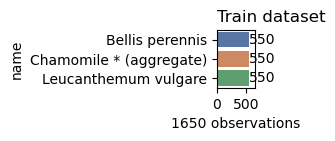

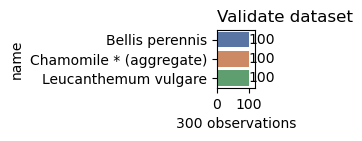

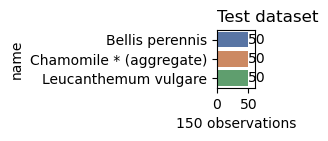

In [307]:
train_data = pandas.read_csv(f'data_loaders/train_data_{group}_{seed}').to_dict('records')
validate_data= pandas.read_csv(f'data_loaders/validate_data_{group}_{seed}').to_dict('records')
test_data = pandas.read_csv(f'data_loaders/test_data_{group}_{seed}').to_dict('records')

print("The train set has", len(train_data), "observations.")
print("The validate set has", len(validate_data), "observations.")
print("The test set has", len(test_data), "observations.")

plot_data = pandas.DataFrame(train_data).groupby(by=["name"])["width"].count().rename("observations").reset_index().sort_values(by=["observations", "name"])
barplot(plot_data, "name", "observations", "Train dataset")

plot_data = pandas.DataFrame(validate_data).groupby(by=["name"])["width"].count().rename("observations").reset_index().sort_values(by=["observations", "name"])
barplot(plot_data, "name", "observations", "Validate dataset")

plot_data = pandas.DataFrame(test_data).groupby(by=["name"])["width"].count().rename("observations").reset_index().sort_values(by=["observations", "name"])
barplot(plot_data, "name", "observations", "Test dataset")

# 🌷 Species
An overview of the species that the model will be trained on.

The species that the model will be trained on are:


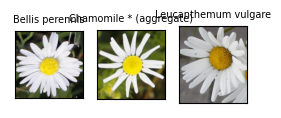

In [278]:
import matplotlib, math

print("The species that the model will be trained on are:")
df_species = pandas.DataFrame(train_data)
df_species["size"] = df_species.apply(lambda x: (x["xmax"] - x["xmin"]) * (x["ymax"] - x["ymin"]), axis=1)
df_species = df_species.sort_values("size", ascending=False).drop_duplicates(["name"]).sort_values("name")
plot_data = df_species.to_dict("records")
rows = math.ceil(len(plot_data)/4)
cols = len(species)
fig, subplots = matplotlib.pyplot.subplots(nrows=rows, ncols=cols, figsize=(len(plot_data), len(plot_data)*1.5))
subplots = subplots.flatten()
for i, file in enumerate(plot_data):
    img = PIL.Image.open(os.path.join(input_path, file["filename"]))
    img = img.crop((file["xmin"], file["ymin"], file["xmax"], file["ymax"]))
    
    subplots[i].imshow(img)
    subplots[i].set_title(file["name"], size = 7)
for i in range(rows * cols):
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

In [303]:
class Dataset(VisionDataset):
    def __init__(self, root, data, classes, transforms=None, transform=None, target_transform=None):
        super().__init__(root, transforms, transform, target_transform)
        self.classes = classes
        self.images = glob.glob(os.path.join(self.root, "*.jpg"))
        self.data = data
        images = []
        metadata = []
        for obj in data:
            filename = obj["filename"]
            if not filename in images:
                images.append(filename)
                metadata_image = []
                for cls_index in range(1, len(classes)):
                    key = classes[cls_index].replace(' ','_')
                    metadata_image.append(obj[key]) 
                metadata.append(metadata_image)
        self.images = images
        self.metadata = metadata
        self.transforms=transforms

    def __getitem__(self, i):
        image_path = os.path.join(self.root, self.images[i])
        image = PIL.Image.open(image_path).convert("RGB")
        objects, labels = [], []
        records = [x for x in self.data if x["filename"] == self.images[i]]
        for record in records:
            objects.append([int(record["xmin"]), int(record["ymin"]), int(record["xmax"]), int(record["ymax"])])
            if self.classes.index(record["name"]) == '__background__':
                print(self.classes.index(record["name"]))
            labels.append(self.classes.index(record["name"]))

        boxes = torch.as_tensor(objects, dtype=torch.float32)
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(labels)
        target["image_id"] = torch.tensor([i])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0]) if len(boxes) > 0 else torch.zeros(1)
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)
        #target["file_name"] = self.images[i]
        if self.transforms is not None:
            image = self.transforms(image)
        tensor = to_tensor(image)

        import numpy
        metadata = self.metadata[i]
        metadata = numpy.array(metadata, dtype=numpy.float32)
        metadata = torch.from_numpy(metadata)

        return tensor, target, metadata
    
    def __len__(self):
        return len(self.images)

train_transforms = transforms.Compose([
        transforms.RandomAdjustSharpness(sharpness_factor=4),
        transforms.RandomAutocontrast()
        #transforms.RandomPerspective(distortion_scale=0.1, p=1.0)
])

classes = []
classes.append("__background__")
for x in species:
    classes.append(x)
print("Classes:", classes)

train_dataset = Dataset(input_path, train_data, classes)#, transforms=train_transforms)
print("The train dataset contains", len(train_dataset), "images.")
validate_dataset = Dataset(input_path, validate_data, classes)
print("The validate dataset contains", len(validate_dataset), "images.")
test_dataset = Dataset(input_path, test_data, classes)
print("The test dataset contains", len(test_dataset), "images.")

Classes: ['__background__', 'Bellis perennis', 'Chamomile * (aggregate)', 'Leucanthemum vulgare']
The train dataset contains 325 images.
The validate dataset contains 44 images.
The test dataset contains 31 images.
[{'filename': '20210601201752-Roadside___tile-a5.jpg', 'width': 1440, 'height': 1238, 'name': 'Chamomile * (aggregate)', 'xmin': 468, 'ymin': 558, 'xmax': 593, 'ymax': 662, 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'date': '2021-06-01 20:17:52', 'day': 152, 'Bellis_perennis': 0, 'Chamomile_*_(aggregate)': 0, 'Leucanthemum_vulgare': 0}, {'filename': '20210601201752-Roadside___tile-a5.jpg', 'width': 1440, 'height': 1238, 'name': 'Chamomile * (aggregate)', 'xmin': 748, 'ymin': 195, 'xmax': 884, 'ymax': 324, 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'occluded': 0, 'date': '2021-06-01 20:17:52', 'day': 152, 'Bellis_perennis': 0, 'Chamomile_*_(aggregate)': 0, 'Leucanthemum_vulgare': 0}, {'filename': '20220421182024-Roadside___tile-c3.jpg', 

# 📉 Create a learning rate scheduler
A Stochastic Gradient Descent optimizer is used to create a stepping learning rate scheduler. The learning rate scheduler reduces the learning rate of the model over a period of time, to make sure that the cost function can minimize. Alternatively to SGD another optimizer could be used, for example ADAM, but it was not tried yet.

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.SGD(params, lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3)

# ♻️ Prepare data loaders and a maximum number of epochs
A data loader arranges for the data in the dataset to be loaded into the memory of the system in batches. It is possible to increase the batch size if enough free memory is available. An epoch is one complete iteration through all the images in the data set. Going over the complete dataset multiple times allows the model to train on more specifics. Model training automatically stops if there is no more to be gained by running another epoch, however, a maximum number of epochs can be specified to stop before then.

- `batch_size` The number of images per step to load into memory.
- `max_epochs` The maximum number of times to go through the complete dataset.

In [ ]:
batch_size = 1
max_epochs = 20
epochs = 20

def seed_worker():
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(42)
    random.seed(42)

g = torch.Generator()
g.manual_seed(42)

seed_worker()

def collate(batch):
    return tuple(zip(*batch))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate, worker_init_fn=seed_worker, generator=g)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate, worker_init_fn=seed_worker, generator=g)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate, worker_init_fn=seed_worker, generator=g)

# ▶️ Run the train + validate loop
The object detection reference scripts from PyTorch vision will be used to run a train + validate loop. The functions `train_one_epoch` and `evaluate` are called a maximum number of times specified by `max_epoch` or until the point of early stopping is reached, calculated by finding no more gain in validation performance. Also, every iteration the learning rate scheduler steps up. The outcomes of the `train_one_epoch` and the `evaluate` functions are collected and parsed such that a report can be generated.

In [ ]:
def confusion_matrix(model, data_loader, device, score_threshold, iou_threshold=.5):
    import torchvision.ops.boxes as bops
    num_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    classes_ = []
    for _, targets, meta in data_loader:
        for c in targets[0]["labels"].detach().tolist():
            if c not in classes_:
                classes_.append(c)
    matrix_size = len(classes) #+ 1 # Add one for background.
    matrix = [[0 for x in range(matrix_size)] for y in range(matrix_size)]
    
    count = 0
    for images, targets, meta in data_loader:
        i = list(img.to(device) for img in images)
        m = list(met.to(device) for met in meta)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        output = model(i, meta_data=m)

        output[0]["boxes"] = output[0]["boxes"][output[0]["scores"] >= score_threshold]
        output[0]["labels"] = output[0]["labels"][output[0]["scores"] >= score_threshold]
        output[0]["scores"] = output[0]["scores"][output[0]["scores"] >= score_threshold]

        output = [{k: v.to(cpu_device) for k, v in t.items()} for t in output]

        predictions = output[0]["boxes"]
        prediction_labels = output[0]["labels"].detach().tolist()
        truths = targets[0]["boxes"]
        truth_labels = targets[0]["labels"].detach().tolist()
        ious = bops.box_iou(predictions, truths)
        matches = []
        for pid, prediction in enumerate(predictions.detach().tolist()):
            found = False
            for tid, iou in enumerate(ious.detach().tolist()[pid]):
                if iou >= iou_threshold:
                    matches.append([pid, tid, iou])
                    found = True       
            if not found:
                matrix[0][prediction_labels[pid]] += 1
                
        matches.sort(key=lambda x: x[2], reverse=True)
        tids, pids = [], []
        for match in matches:
            if match[1] not in tids:
                if match[0] not in pids:
                    tids.append(match[1])
                    pids.append(match[0])
                    matrix[truth_labels[tid]][prediction_labels[pid]] += 1
            else:
                matrix[0][prediction_labels[pid]] += 1    
                
        for tid, truth in enumerate(truths.detach().tolist()):
            if tid not in tids:
                matrix[truth_labels[tid]][0] += 1
        
    torch.set_num_threads(num_threads)
    
    return matrix
matrix5=[]
matrix7=[]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
freq = math.ceil(len(train_dataset) / batch_size / 4)
report, early_stop_metrics = [], []
for epoch in range(epochs):
    epoch += 1
    train_result = train_one_epoch(model, optimizer, train_loader, device, epoch, freq)
    train_metrics = train_result.__str__()
    eval_result = evaluate(model, validate_loader, device=device)
    conv5 = confusion_matrix(model, validate_loader, device, 0.5, 0.5)
    conv7 = confusion_matrix(model, validate_loader, device, 0.7, 0.5)
    matrix5.append(conv5)
    matrix7.append(conv7)
    buffer = io.StringIO()
    with contextlib.redirect_stdout(buffer): # Little trick to capture eval_result.summarize() into a buffer.
        eval_result.summarize()
    eval_metrics = buffer.getvalue()
    record = objectdetectiontools.parser.parse_pycoco_metrics(epoch, train_metrics, eval_metrics)
    report.append(record)
    scheduler.step()
    early_stop_metric = record["Average Precision @.50:.95IoU "]
    early_stop_metrics.append(early_stop_metric)
    if len(early_stop_metrics) > 20 and early_stop_metric <= statistics.mean(early_stop_metrics[-5:]):
        print("Early stopped at epoch", epoch, "result:", early_stop_metric, "<= mean(", early_stop_metrics[-5:], ")")
        epochs = len(early_stop_metrics)
        break

# ⚖️ Show train and validation metrics report
The collected training and validation metrics report is shown below. The first four metrics about loss refer to the loss during training. The 12 metrics after that are COCO generated validation metrics over all the epochs.

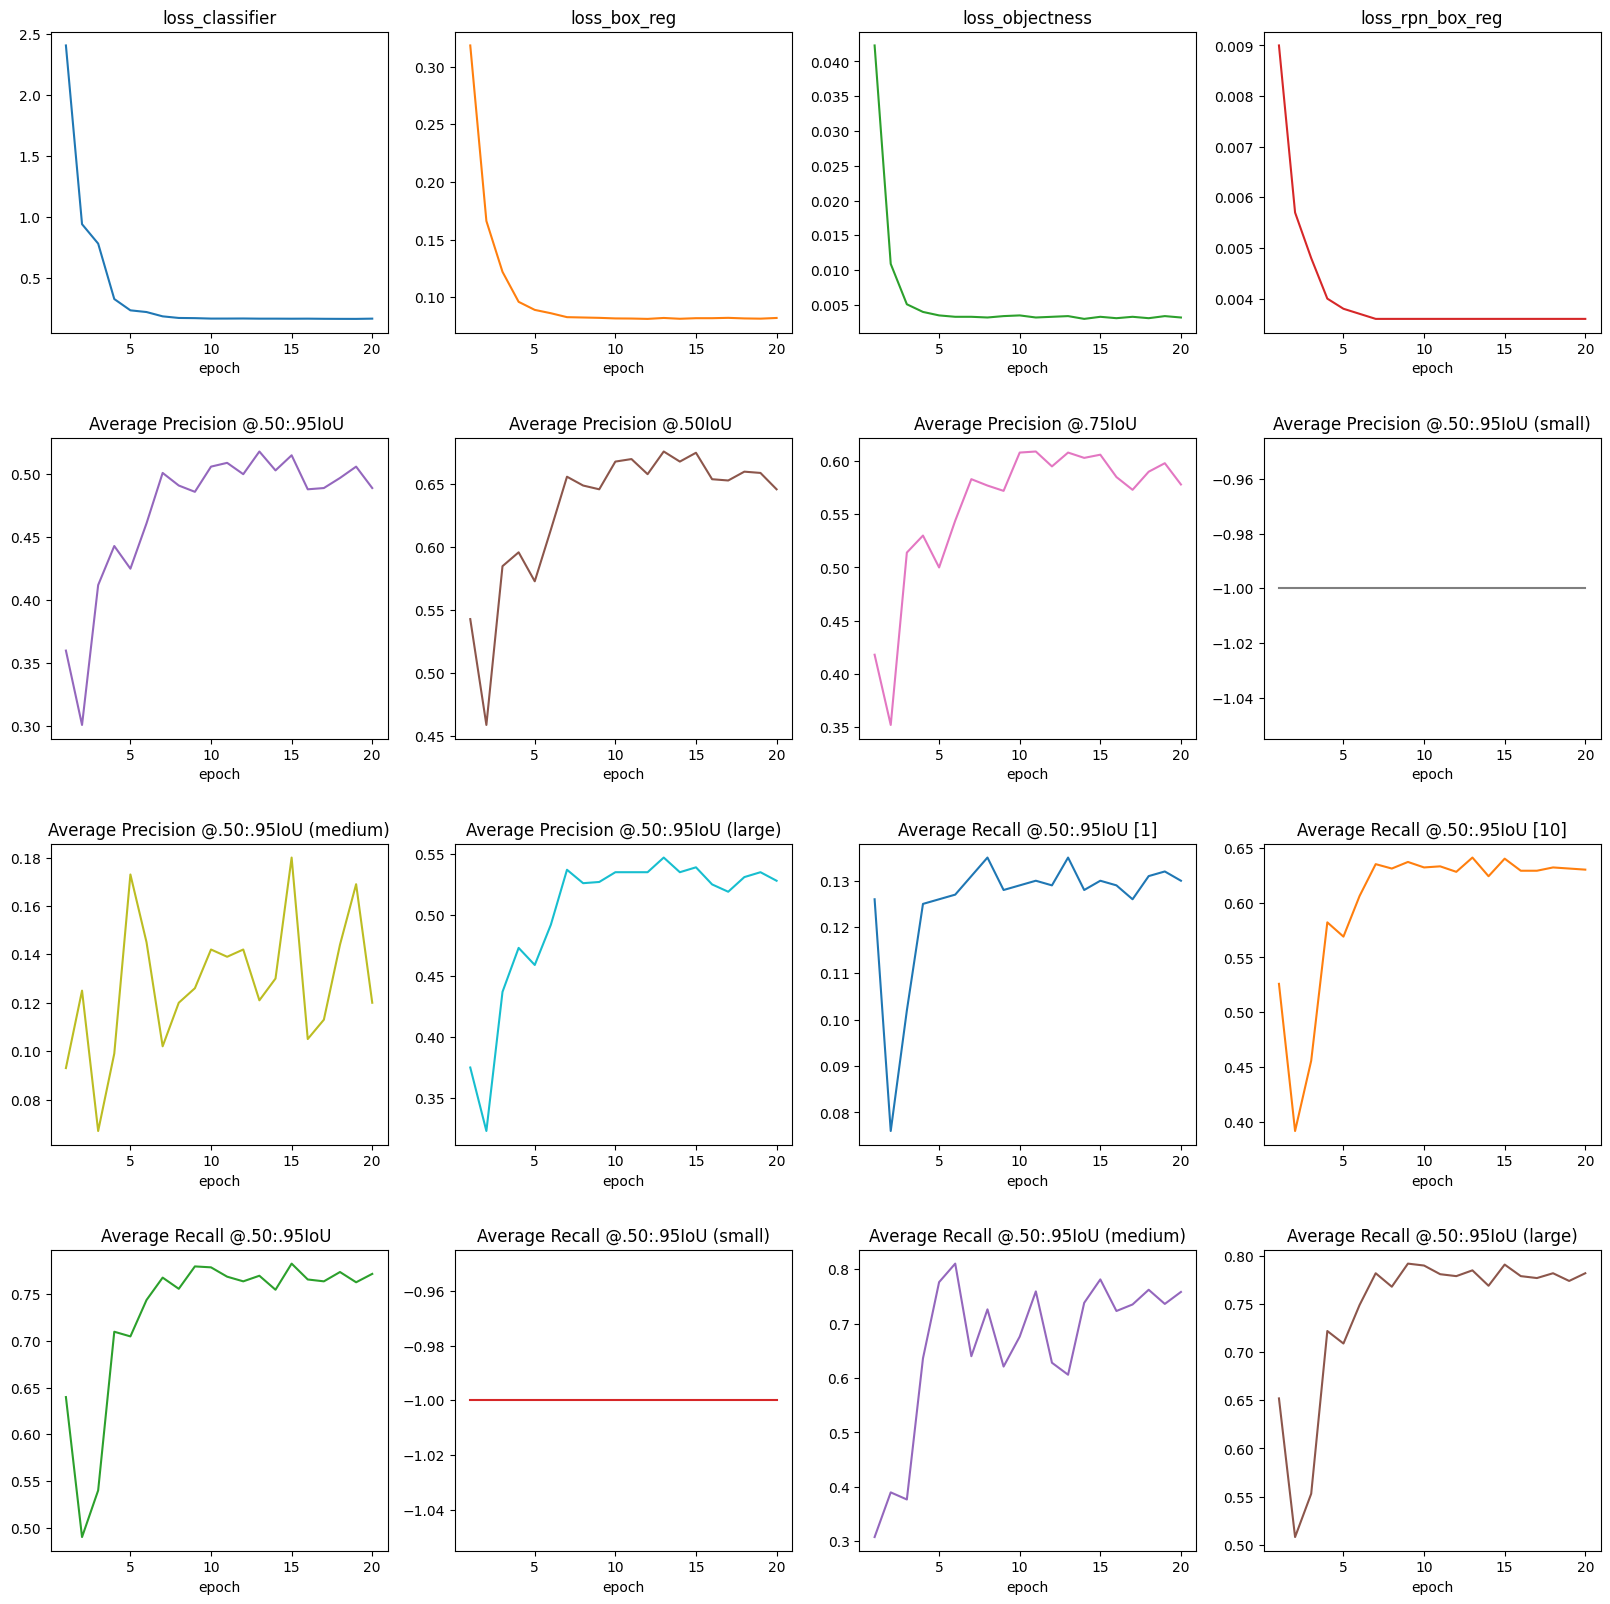

In [ ]:
metrics = pandas.DataFrame(report)
metrics.plot(subplots=True, layout=(5,4), figsize=(20,25), x="epoch", sharex=False, title=metrics.columns.to_list()[1:], legend=False)
plt.subplots_adjust(hspace=0.35)

conv5 = pandas.DataFrame(matrix5)
conv7 = pandas.DataFrame(matrix7)

conv5.to_csv(f'confusion_matrix_group{group}_epoch{epochs}_seed{seed}_batch{batch_size}_score0.5_{model_name}_{mode}{"_learned" if learned_feature is True else ""}.csv')
conv7.to_csv(f'confusion_matrix_group{group}_epoch{epochs}_seed{seed}_batch{batch_size}_score0.7_{model_name}_{mode}{"_learned" if learned_feature is True else ""}.csv')

metrics.to_csv(f'metrics_group{group}_epoch{epochs}_seed{seed}_batch{batch_size}_{model_name}_{mode}{"_learned" if learned_feature is True else ""}.csv')

# ✅ Run against the test data
Now the model is ran against the earlier separated test dataset to get the COCO metrics per class. And again to create a confusion matrix.

creating index...
index created!


/tmp/ipykernel_186233/3654096172.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metadata = (torch.tensor(meta_data)).repeat((int)(x.size(dim=0)), 1).to("cuda")


Test:  [ 0/30]  eta: 0:00:07  model_time: 0.1810 (0.1810)  evaluator_time: 0.0104 (0.0104)  time: 0.2374  data: 0.0404  max mem: 7150
Test:  [29/30]  eta: 0:00:00  model_time: 0.0725 (0.0746)  evaluator_time: 0.0010 (0.0017)  time: 0.1116  data: 0.0323  max mem: 7150
Test: Total time: 0:00:03 (0.1151 s / it)
Averaged stats: model_time: 0.0725 (0.0746)  evaluator_time: 0.0010 (0.0017)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

<Axes: ylabel='Class'>

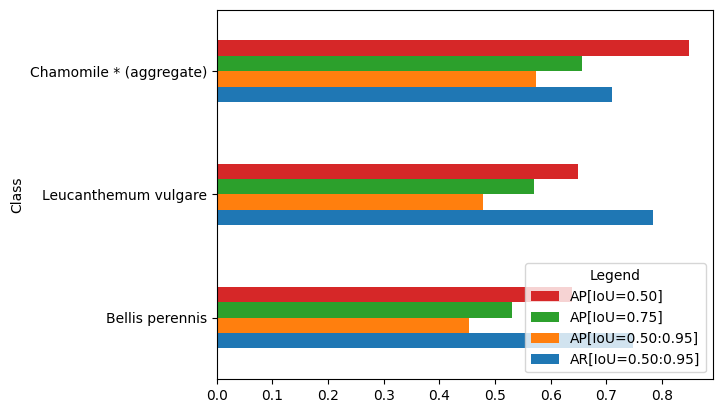

In [ ]:
def coco_evaluator_class_metrics(model, test_loader, device): # function copied from COCOJumboo package.
    import numpy as np 
    coco_evaluator = evaluate(model, test_loader, device)
    for iou_type in coco_evaluator.iou_types:
        cocoEval = coco_evaluator.coco_eval[iou_type]
        catIds = cocoEval.params.catIds
        params  = cocoEval.params
        dict = cocoEval.eval
        iStrTable = '{}[IoU={IoUStr}]' 
        iStr = ' {:<18} {} @[ IoU={IoUStr:<9} | area={areaStr:>6s} | maxDets={maxDetsStr:>3d} | label={labelStr} ]'
        aind = [i for i, aRng in enumerate(params.areaRngLbl) if aRng == 'all']
        mind = [i for i, mDet in enumerate(params.maxDets) if mDet == 100]
        table, columns = [], []
        columns.append('Class')
        for cat in range(len(catIds)):
            item = []
            item.append(catIds[cat])
            for iouThr in [None, 0.50, 0.75]:
                precision = dict['precision']
                if iouThr is not None:
                    t = np.where(iouThr == params.iouThrs)[0]
                    precision = precision[t]
                precision = precision[:,:,:,aind,mind]
                if len(precision[precision>-1])==0:
                    mean_precision = -1
                else:
                    mean_precision = np.mean(precision[:,:,cat,:])
                    iouStr = '{:0.2f}:{:0.2f}'.format(params.iouThrs[0], params.iouThrs[-1]) \
                    if iouThr is None else '{:0.2f}'.format(iouThr)
                    info = iStr.format('Average Precision', 'AP', IoUStr=iouStr, areaStr='all', maxDetsStr=100, labelStr=cat)
                    info_table = iStrTable.format('AP', IoUStr=iouStr)
                    if info_table is None:
                        columns.append(info_table)
                    else:
                        if info_table not in columns:
                            columns.append(info_table)
                    item.append(mean_precision)
            iouThr = None
            recall = dict['recall']
            if iouThr is not None:
                t = np.where(iouThr == params.iouThrs)[0]
                recall = recall[t]
            recall = recall[:,:,aind,mind]
            if len(recall[recall>-1])==0:
                mean_recall = -1
            else:
                mean_recall = np.mean(recall[:,cat,:])
                iouStr = '{:0.2f}:{:0.2f}'.format(params.iouThrs[0], params.iouThrs[-1]) \
                    if iouThr is None else '{:0.2f}'.format(iouThr)
                info = iStr.format('Average Recall', 'AR', IoUStr=iouStr, areaStr='all', maxDetsStr=100, labelStr=cat)
                info_table = iStrTable.format('AR', IoUStr=iouStr)
                if info_table not in columns:
                    columns.append(info_table)
                item.append(mean_recall)    
            table.append(item)  
    return table, columns 

results, metrics = coco_evaluator_class_metrics(model, test_loader, device)

df_testresults = pandas.DataFrame(results, columns=metrics)

df_testresults.to_csv(f'eval_coco_metrics_group{group}_epoch{epochs}_seed{seed}_batch{batch_size}_{model_name}_{mode}{"_learned" if learned_feature is True else ""}.csv') # to change

col = df_testresults.pop("AR[IoU=0.50:0.95]")
df_testresults.insert(1, col.name, col)
col = df_testresults.pop("AP[IoU=0.50]")
df_testresults.insert(4, col.name, col)
df_testresults = df_testresults.sort_values(by="AP[IoU=0.50]")

df_testresults["Class"] = df_testresults["Class"].map(dict(enumerate(classes)))
plot = df_testresults.plot(kind="barh", x="Class")
handles, labels = plot.get_legend_handles_labels()
plot.legend(handles[::-1], labels[::-1], title="Legend", loc='best')
plot

In [ ]:
from torchvision.utils import draw_bounding_boxes

def tensor_from_image(image):
    return transforms.pil_to_tensor(image).unsqueeze(dim=0)

def add_bounding_boxes(image, classes, predictions, font_size, color, factor):

    if len(predictions[0]["boxes"]) == 0:
        return image
    annotations = []
    
    for p in predictions[0]["labels"].detach().numpy():
        annotations.append({'name': classes[p]})

    if 'scores' in predictions[0]:
        labels = ["Predicted: {} {}%".format(label["name"], int(prob *100)) for label, prob in zip(annotations, predictions[0]["scores"].detach().numpy())]
        boxes = predictions[0]["boxes"]

        # print(boxes)
        # print(labels)
    else:
        boxes = predictions[0]["boxes"]
        # print(boxes)
        labels_id = predictions[0]["labels"].numpy()
        
        labels=[]
        for id in labels_id:
            labels.append(f"True: {classes[id]}")
        # print(labels)

    output = draw_bounding_boxes((image[0]*factor).to(torch.uint8),
                                boxes= boxes,
                                labels=labels,
                                colors=color,
                                #width=1,
                                #font="arial.ttf",
                                font_size=font_size)
    return output

/tmp/ipykernel_186233/3654096172.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metadata = (torch.tensor(meta_data)).repeat((int)(x.size(dim=0)), 1).to("cuda")
/opt/conda/lib/python3.10/site-packages/torchvision/utils.py:223: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


[[0, 12, 7, 8], [6, 43, 0, 1], [3, 1, 40, 6], [9, 9, 13, 19]]


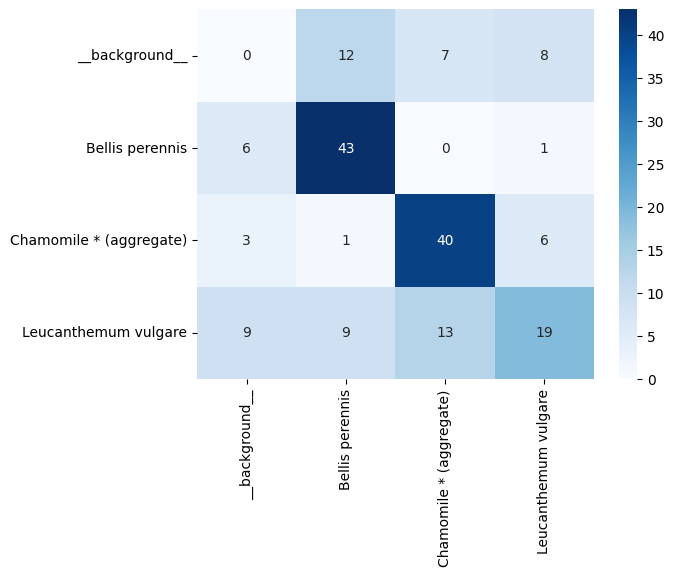

In [ ]:
def generate_confusion_matrix(model, device, data_loader, score_threshold, iou_threshold=.5):
    import torchvision.ops.boxes as bops
    num_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model = model.to(device)
    model.eval()
    classes_ = []
    for _, targets, meta in data_loader:
        for c in targets[0]["labels"].detach().tolist():
            if c not in classes_:
                classes_.append(c)
    matrix_size = len(classes) #+ 1 # Add one for background.
    matrix = [[0 for x in range(matrix_size)] for y in range(matrix_size)]
    
    count = 0
    for images, targets, meta in data_loader:
        i = list(img.to(device) for img in images)
        m = list(met.to(device) for met in meta)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        output = model(i, meta_data=m)

        output[0]["boxes"] = output[0]["boxes"][output[0]["scores"] >= score_threshold]
        output[0]["labels"] = output[0]["labels"][output[0]["scores"] >= score_threshold]
        output[0]["scores"] = output[0]["scores"][output[0]["scores"] >= score_threshold]

        output = [{k: v.to(cpu_device) for k, v in t.items()} for t in output]
       
        
        predictions = output[0]["boxes"]
        prediction_labels = output[0]["labels"].detach().tolist()
        truths = targets[0]["boxes"]
        truth_labels = targets[0]["labels"].detach().tolist()
        ious = bops.box_iou(predictions, truths)
        matches = []
        for pid, prediction in enumerate(predictions.detach().tolist()):
            found = False
            for tid, iou in enumerate(ious.detach().tolist()[pid]):
                if iou >= iou_threshold:
                    matches.append([pid, tid, iou])
                    found = True       
            if not found:
                matrix[0][prediction_labels[pid]] += 1
                
                
        matches.sort(key=lambda x: x[2], reverse=True)
        tids, pids = [], []
        for match in matches:
            if match[1] not in tids:
                if match[0] not in pids:
                    tids.append(match[1])
                    pids.append(match[0])
                    matrix[truth_labels[tid]][prediction_labels[pid]] += 1
            else:
                matrix[0][prediction_labels[pid]] += 1      
                
        for tid, truth in enumerate(truths.detach().tolist()):
            if tid not in tids:
                matrix[truth_labels[tid]][0] += 1
                
        count += 1

    torch.set_num_threads(num_threads)
    
    return matrix

score = 0.7
matrix = generate_confusion_matrix(model, device, test_loader, score_threshold=score, iou_threshold=.5)# generate_confusion_matrix(model, device, test_loader)
seaborn.heatmap(matrix, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues").figure.savefig(
   f'heatmap_group{group}_epoch{epochs}_seed{seed}_batch{batch_size}_score{score}_{model_name}_{mode}{"_learned" if learned_feature is True else ""}.png', bbox_inches='tight', dpi=600)

print(matrix)


# 💾 Save the model
The model is saved to disk using the pytorch default `model.state_dict()` that produces a file can be loaded again later.

In [ ]:
model_output_path = os.path.join(output_path, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
os.makedirs(model_output_path)
torch.save(model.state_dict(), os.path.join(model_output_path, "model"))
f = open(os.path.join(model_output_path, "classes.json"), 'w')
json.dump(classes, f)
f.close()

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [ ]:
import IPython
filename = IPython.extract_module_locals()[1]['__vsc_ipynb_file__']
if filename != "":
    os.system("python -m nbconvert --output-dir=" + model_output_path + " --to html " + os.path.basename(filename))

[NbConvertApp] WARNING | pattern 'copy.ipynb' matched no files
[NbConvertApp] Converting notebook flowerpower.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 7334606 bytes to output/20240512185953/flowerpower.html
